In [43]:
%load_ext autoreload
%autoreload 2

from src.distributions import VonMisesFisher, SphereUniform
import matplotlib.pyplot as plt
import torch
import plotly.express as px
import seaborn as sns
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The uniform distribution
The source code for the distributions can be seen in the `src/distributions.py` file. Below, the uniform distribution is tested. This distribution will be used in the vMF sampling.

In [44]:
su = SphereUniform(2)
x, y, z = su.sample(torch.Size([100])).T
px.scatter_3d(x=x, y=y, z=z)

# Von Mises Fisher

Below, the sampling procedure is laid out for vMF. We are sampling from 4 different mean vectors, with different concentration parameters

In [45]:
mu = torch.tensor([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1],
    [0, -1/math.sqrt(2), 1/math.sqrt(2)],
])
k = torch.tensor([5, 10, 50, 10])
m = torch.tensor( mu.shape[-1] )


sample_shape = torch.Size([100]) # Lets sample a bunch of samples for each parameter set
batch_shape = torch.Size(mu.shape[:-1])
event_shape = torch.Size([m])

The sampling algorithm defines the following parameters and distributions

In [46]:
b = ( -2 * k + torch.sqrt( 4 * k**2 + (m - 1)**2 )) / (m - 1) 
a = ( (m - 1) + 2 * k + torch.sqrt( 4 * k**2 + (m - 1)**2 ) ) / 4
d = (4 * a * b) / (1 + b) - (m - 1) * torch.log(m - 1)

print(f"b:{b}")
print(f"a:{a}")
print(f"d:{d}")
beta_dist = torch.distributions.Beta((m-1)/2, (m-1)/2)
uniform_subsphere_dist = SphereUniform(m-2)

print(f"beta_dist:{beta_dist}")
print(f"uniform_subsphere_dist:{uniform_subsphere_dist}")

modal = torch.tensor([1, 0, 0])
u_prime = modal - mu
u = u_prime / u_prime.norm(dim=-1, keepdim=True)
U = torch.eye(m) - 2 * u.view(-1, m, 1) @ u.view(-1, 1, m)
print(f"Householder:{U}")

b:tensor([0.0990, 0.0499, 0.0100, 0.0499])
a:tensor([ 5.5495, 10.5249, 50.5050, 10.5249])
d:tensor([0.6137, 0.6137, 0.6136, 0.6137])
beta_dist:Beta()
uniform_subsphere_dist:SphereUniform()
Householder:tensor([[[ 5.9605e-08,  1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  5.9605e-08,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 5.9605e-08,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  5.9605e-08]],

        [[ 5.9605e-08, -7.0711e-01,  7.0711e-01],
         [-7.0711e-01,  5.0000e-01,  5.0000e-01],
         [ 7.0711e-01,  5.0000e-01,  5.0000e-01]]])


The code below samples the $\omega$ values

In [53]:
done = torch.zeros( sample_shape + batch_shape, dtype=bool)
w = torch.zeros(sample_shape + batch_shape, dtype=torch.float)

# Proper vectorizing?
while True:

    mask = ~done
    n_left = mask.sum()
    if n_left == 0:
        break

    a_ = torch.masked_select(a, mask)
    b_ = torch.masked_select(b, mask)
    d_ = torch.masked_select(d, mask)

    epsilon = beta_dist.sample( (n_left,) )
    
    w_proposal = (1 - (1 + b_) * epsilon) / (1 - (1 - b_) * epsilon)
    t = 2 * a_ * b_ / (1 - (1 - b_) * epsilon)

    u = torch.rand( n_left )
    accepted = (m - 1) * torch.log(t) - t + d_ >= torch.log(u)

    torch.masked_select(w_proposal, accepted)

    # Find values of 
    mask[mask.clone()] &= accepted
    w[mask] = w_proposal[accepted]
    done[mask] = True
 

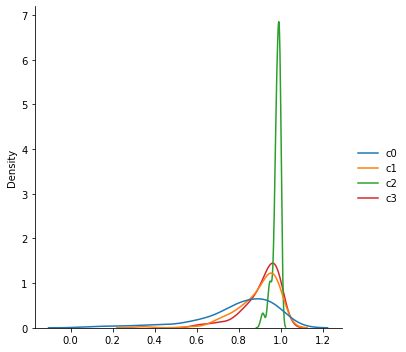

In [48]:
sns.displot(
    {f"c{i}" : x for i, x in enumerate(w.T)},
    kind='kde',

);

In [49]:
# Sample from subsphere
v = uniform_subsphere_dist.sample( sample_shape + batch_shape )

In [50]:
z_prime = torch.cat([w.unsqueeze(-1), v * torch.sqrt(1 - w**2).unsqueeze(-1)], -1)

In [51]:
z = (U.view(
    torch.Size( batch_shape + (m, m) )
) @ z_prime.view( 
    sample_shape + batch_shape + (m, 1) 
)).squeeze()

In [52]:
from plotly import graph_objects as go

fig = go.Figure()
for i in range(4):
    x, y, z_ = z[:, i, :].T
    fig.add_trace((go.Scatter3d(
        x=x, 
        y=y, 
        z=z_, 
        mode="markers"
    )))
fig